In [10]:
import os
import pandas as pd
import numpy as np
import torch.nn as nn
from torchvision.transforms import Resize, Grayscale
from torchvision.io import read_image
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Get and handle MNIST Data

In [3]:
batchSize = 64

trainDataset = datasets.MNIST('/content', train=True, download=True, transform=transforms.Compose([
                                                              transforms.ToTensor(), # convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs, mean=0.1307 and standard deviation=0.3081 are precomputed statistics of the entire dataset
                                                          ])) # size = 28X28
trainData = list(trainDataset)[:5000]
trainDataLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True)

valDataset = datasets.MNIST('/content', train=False, download=True, transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307,), (0.3081,))
                                                          ]))
valData = list(valDataset)[:2500]
valDataLoader = DataLoader(valData, batch_size=batchSize, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 304109420.79it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38912847.36it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 122182417.83it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18477719.46it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



Define Layers

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # convolution layer1, inputNum = 1 because monochrome
        self.conv2 = nn.Conv2d(32, 64, 3) # convolution layer2
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) # pooling layer

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.flatten = nn.Flatten()

        # fully connected layer
        # input = 9216 = sizeOfLastLayerMatrix * LastLayerChannelNum = 12*12*64, 
        # sizeOfLastLayerMatrix(of one side) = floor(((((sizeOfImg - layer1KernelSize + 1) - layer2KernelSize + 1) - maxPoolKernelSize) / maxPoolStride) + 1)
        # = floor(((((28-3+1)-3+1)-2)/2)+1)=12
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10) # output fully connected layer, outputNum = 10 because predict 0~9


    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.max_pool(torch.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc2(x))
        return x

Define LossFunc and Optimizer

In [5]:
model = Net().to(device)

learningRate = 1e-3
lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

Start Learning and cal ACC by Val Data

In [6]:
valLosses = []
epochesN = 30
for epoch in range(epochesN):
    acc = 0
    allValNum = 0
    for xTrainBatch, zTrainBatch in trainDataLoader:
        xTrainBatch = xTrainBatch.to(device)
        zTrainBatch = zTrainBatch.to(device)
        outputs = model(xTrainBatch)

        loss = lossFn(outputs, zTrainBatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for xValBatch, zValBatch in valDataLoader:
            xValBatch = xValBatch.to(device)
            zValBatch = zValBatch.to(device)

            outputs = model(xValBatch)
            valLossBatch = lossFn(outputs, zValBatch)
            valLosses.append(valLossBatch.cpu().item())

            acc += (torch.argmax(outputs,dim=1) == zValBatch).cpu().sum().item() # cal acc
            allValNum += zValBatch.size()[0]
    print(f'epoch:{epoch+1}')
    print(f'val acc is {(acc/allValNum)*100}%')

epoch:1
val acc is 82.08%
epoch:2
val acc is 89.16%
epoch:3
val acc is 89.2%
epoch:4
val acc is 90.96%
epoch:5
val acc is 92.52%
epoch:6
val acc is 90.92%
epoch:7
val acc is 92.60000000000001%
epoch:8
val acc is 93.2%
epoch:9
val acc is 93.76%
epoch:10
val acc is 93.36%
epoch:11
val acc is 93.0%
epoch:12
val acc is 93.12%
epoch:13
val acc is 93.67999999999999%
epoch:14
val acc is 93.64%
epoch:15
val acc is 93.76%
epoch:16
val acc is 94.32000000000001%
epoch:17
val acc is 94.72%
epoch:18
val acc is 93.88%
epoch:19
val acc is 93.8%
epoch:20
val acc is 94.19999999999999%
epoch:21
val acc is 94.32000000000001%
epoch:22
val acc is 94.24%
epoch:23
val acc is 94.12%
epoch:24
val acc is 94.08%
epoch:25
val acc is 94.84%
epoch:26
val acc is 94.36%
epoch:27
val acc is 93.8%
epoch:28
val acc is 94.8%
epoch:29
val acc is 94.8%
epoch:30
val acc is 94.92%


Use new images to test the Model

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
imgsPath = '/content/drive/MyDrive/data/cnnMNIST'
height = width = 28
labels = ["2", "3", "5", "8", "9"] # labels = filenames

imgTensor = torch.zeros([len(labels), 1, height, width]) # init img tensor
labelTensor = torch.zeros([len(labels)]) # init label tensor
transformResize = Resize((height, width))
transformGrayscale = Grayscale(1)

for i, label in enumerate(labels):
  imgPath = os.path.join(imgsPath, f'{label}.jpg')
  image = transformResize(read_image(imgPath)).float()
  image = transformGrayscale(image)
  image = image / 255 # normalization
  imgTensor[i, :, :, :] = image # put image into tensor
  labelTensor[i] = float(label)

testDataset = TensorDataset(imgTensor, labelTensor)
testDataLoader = DataLoader(testDataset, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Let's check the transformed images

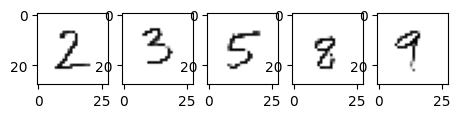

In [52]:
import matplotlib.pyplot as plt

for k, (img, _) in enumerate(testDataset):
    im = np.squeeze(img)
    plt.subplot(3, 6, k+1)
    plt.imshow(im, cmap='gray')

Start Testing

In [48]:
acc = 0
allValNum = 0
with torch.no_grad():
    for xTest, zTest in testDataLoader:
        xTest = xTest.to(device)
        zTest = zTest.float().to(device)
        outputs = model(xTest)

        acc += (torch.argmax(outputs,dim=1) == zTest).cpu().sum().item()
        allValNum += zTest.size()[0]
print(f'test acc is {(acc/allValNum)*100}% in {acc} / {allValNum}')

test acc is 80.0% in 4 / 5
